# Explore the dataset

In [19]:
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pmdarima
warnings.filterwarnings("ignore")

In [21]:
df = pd.read_excel('C:/Users/mikol/Downloads/python/Time Series Analysis/data.xlsx')
#print(df)
df['Date']=pd.to_datetime(df['Date'])
df.describe()

,Date,Value
count,22,22.000000
mean,1970-01-01 00:00:00.000000011,772.636364
min,1970-01-01 00:00:00.000000001,4.000000
25%,1970-01-01 00:00:00.000000006,511.000000
50%,1970-01-01 00:00:00.000000011,662.000000
75%,1970-01-01 00:00:00.000000016,1126.750000
max,1970-01-01 00:00:00.000000022,1501.000000
std,NaN,441.219149


<Axes: xlabel='Date', ylabel='Value'>

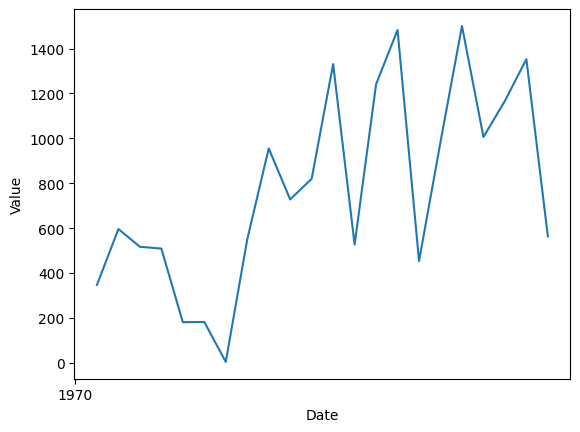

In [22]:
sns.lineplot(data=df,x="Date", y="Value")

<Axes: xlabel='Date', ylabel='Value'>

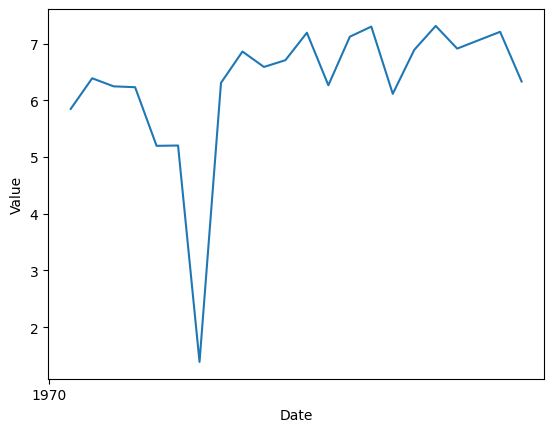

In [23]:
df['Value'] = [math.log(i) for i in df['Value']] #przekształcenie logarytmiczne
sns.lineplot(data=df,x="Date", y="Value")

<Axes: xlabel='Date', ylabel='Value'>

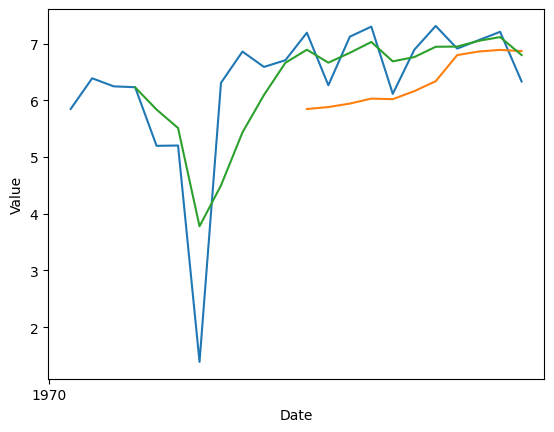

In [24]:
#Moving Average
sns.lineplot(data=df,x="Date", y="Value")
sns.lineplot(data=df, x="Date", y=df.Value.rolling(12).mean()) #MA
weights = np.array([0.1, 0.2, 0.3, 0.4])
sns.lineplot(data=df, x="Date", y=df.Value.rolling(4).apply(lambda x: np.sum(weights*x))) #Weighted MA
#sns.lineplot(data=df, x="Date", y=df.Value.rolling(4).std())

In [25]:
msk = (df.index < len(df)-0) #wielkość próby prognozowanej
df_train = df[msk].copy()
df_test = df[~msk].copy()

# Check for stationarity of time series

## Look at the time series plot or...

## ADF i KPSS test

In [26]:
def adf_test(dataset, **kw):
    dftest = adfuller(dataset, autolag = 't-stat', **kw)
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    if dftest[1] <= 0.05:
        print("Odrzucamy H0, szereg jest stacjonarny")
    else:
        print("Brak podstaw do odrzucenia H0, szereg jest niestacjonarny")

In [27]:
def kpss_test(data, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(data, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:') 
    for key, value in critical_values.items():
        print(f'   {key} : {value}')       
    print(f'Szereg jest {"nie" if p_value < 0.05 else ""}stacjonarny')

## ACF plot and PACF plot

1. ADF :  -1.1898675069800804
2. P-Value :  0.6779391961667318
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 16
5. Critical Values :
	 1% :  -3.9240193847656246
	 5% :  -3.0684982031250003
	 10% :  -2.67389265625
Brak podstaw do odrzucenia H0, szereg jest niestacjonarny
KPSS Statistic: 0.7291272964757248
p-value: 0.010897518502206834
num lags: 1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Szereg jest niestacjonarny


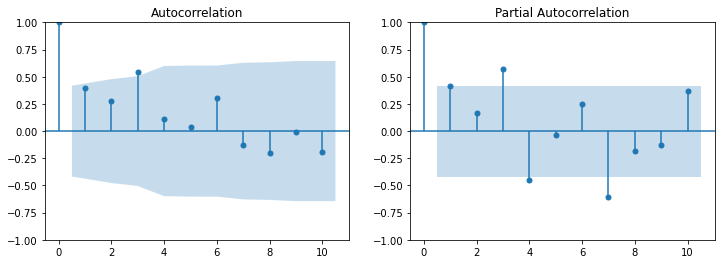

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
acf_original = plot_acf(df_train.Value, ax=ax[0], lags=10)
pacf_original = plot_pacf(df_train.Value, ax=ax[1], lags=10)
adf_test(df_train.Value)
kpss_test(df_train.Value)

## Transform to stationary: differencing

1. ADF :  -3.879916192529138
2. P-Value :  0.002187726539798264
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 190
5. Critical Values :
	 1% :  -3.4652439354133255
	 5% :  -2.8768752281673717
	 10% :  -2.574944653739612
Odrzucamy H0, szereg jest stacjonarny
KPSS Statistic: 0.014910464772682132
p-value: 0.1
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Szereg jest stacjonarny


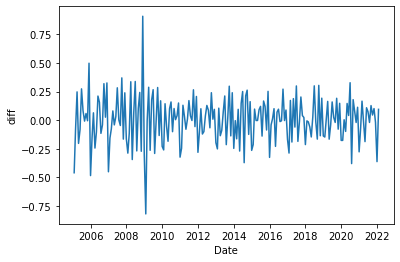

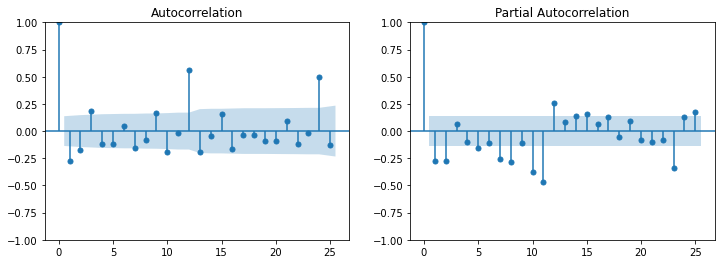

In [164]:
#pierwsze różnicowanie
df_train['diff']=df_train['Value'].diff()
sns.lineplot(data=df_train, x="Date", y="diff")
fig, ax = plt.subplots(1,2, figsize=(12,4))
acf_diff = plot_acf(df_train.loc[1:, 'diff'], ax=ax[0], lags=25)
pacf_diff = plot_pacf(df_train.loc[1:, 'diff'], ax=ax[1], lags=25)
adf_test(df_train.loc[1:, 'diff'])
kpss_test(df_train.loc[1:, 'diff'])

1. ADF :  -10.128828922083263
2. P-Value :  9.030604359793909e-18
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 188
5. Critical Values :
	 1% :  -3.465620397124192
	 5% :  -2.8770397560752436
	 10% :  -2.5750324547306476
Odrzucamy H0, szereg jest stacjonarny


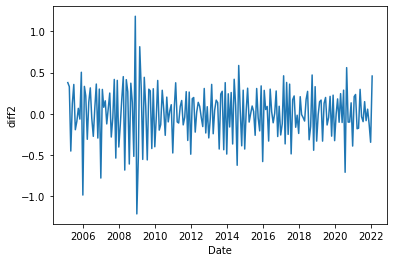

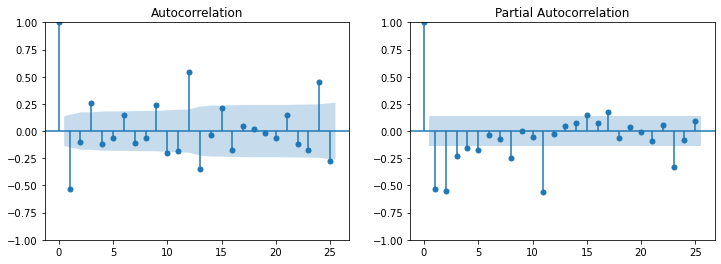

In [11]:
#drugie różnicowanie
df_train['diff2']=df_train['Value'].diff().diff()
sns.lineplot(data=df_train, x="Date", y="diff2")
fig, ax = plt.subplots(1,2, figsize=(12,4))
acf_diff = plot_acf(df_train.loc[2:, 'diff2'], ax=ax[0], lags=25)
pacf_diff = plot_pacf(df_train.loc[2:, 'diff2'], ax=ax[1], lags=25)
adf_test(df_train.loc[2:, 'diff2']) 

In [9]:
acorr_ljungbox(df_train.loc[1:, 'diff'], lags=[24], return_df=True, boxpierce=True) #test ljunga-boxa

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
24,213.65387,2.326319e-32,197.274365,3.519277e-29


In [9]:
d=1 #wybrana liczba różnicowań

# Seasonality

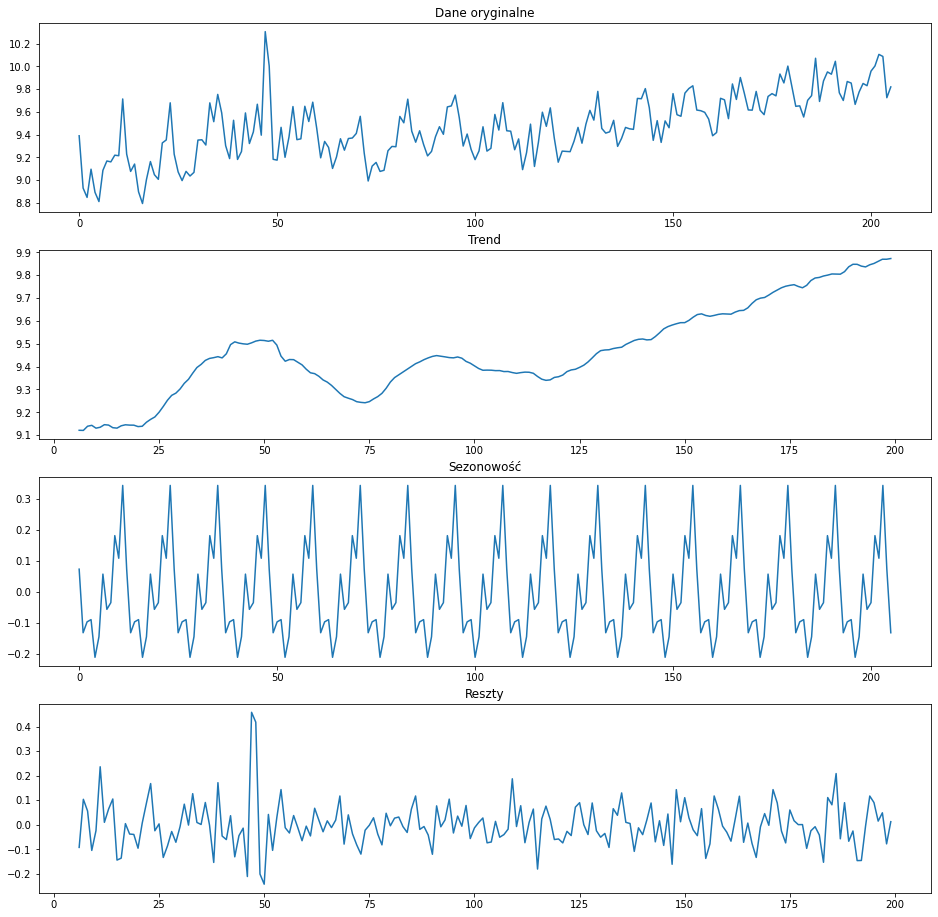

In [10]:
#dekompozycja
M=12 #okres sezonowości
fig, ax = plt.subplots(figsize=(16, 16))
decomposition = seasonal_decompose(df_train['Value'], model='additive',period=M) # multiplicative/additive, extrapolate_trend='freq'

# Wykres danych oryginalnych
plt.subplot(4, 1, 1)
plt.plot(df_train['Value'])
plt.title('Dane oryginalne')

#Wykres trendu
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

# Wykres sezonowości
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Sezonowość')

# Wykres reszt
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Reszty')


plt.show()

1. ADF :  -2325091223589641.0
2. P-Value :  0.0
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 191
5. Critical Values :
	 1% :  -3.465058702600837
	 5% :  -2.8767942675230356
	 10% :  -2.5749014492475535
Odrzucamy H0, szereg jest stacjonarny


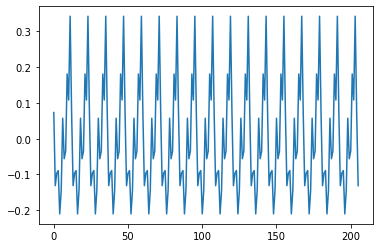

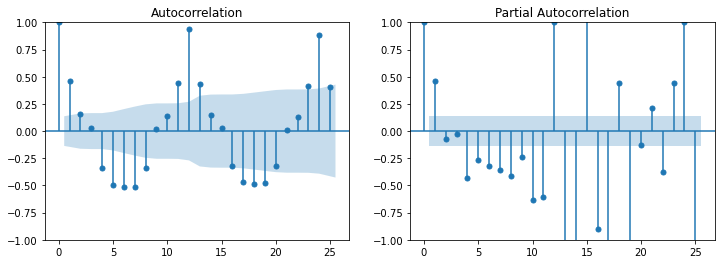

In [11]:
#stacjonarność elementu sezonowego
#SAR(1): S, 2S, 3S dla ACF oraz S dla PACF
#SMA(1): S, 2S, 3S dla PACF oraz S dla ACF
seasonal = decomposition.seasonal #.trend, .resid
seasonal.plot()
fig, ax = plt.subplots(1,2, figsize=(12,4))
acf_diff = plot_acf(seasonal, ax=ax[0], lags=25)
pacf_diff = plot_pacf(seasonal, ax=ax[1], lags=25)
adf_test(seasonal)

1. ADF :  -4.756111235660604
2. P-Value :  6.593493882573579e-05
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 179
5. Critical Values :
	 1% :  -3.4674201432469816
	 5% :  -2.877826051844538
	 10% :  -2.575452082332012
Odrzucamy H0, szereg jest stacjonarny
KPSS Statistic: 0.17508676371435153
p-value: 0.1
num lags: 59
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Szereg jest stacjonarny


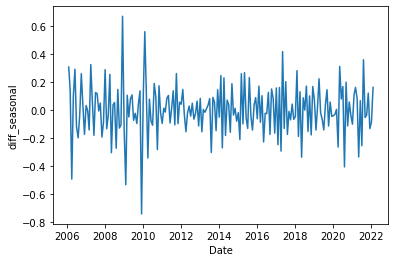

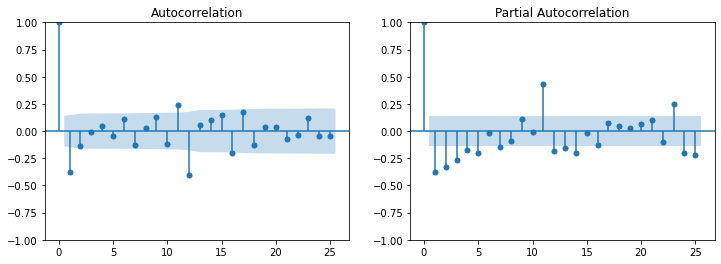

In [12]:
#różnicowanie sezonowe       
df_train['diff_seasonal']=df_train['diff'].diff(periods=M) #w zależności od różnicowania d
sns.lineplot(data=df_train, x="Date", y="diff_seasonal")
fig, ax = plt.subplots(1,2, figsize=(12,4))
acf_diff = plot_acf(df_train.loc[M+d:, 'diff_seasonal'], ax=ax[0], lags=25)
pacf_diff = plot_pacf(df_train.loc[M+d:, 'diff_seasonal'], ax=ax[1], lags=25)
adf_test(df_train.loc[M+d:, 'diff_seasonal'])
kpss_test(df_train.loc[M+d:, 'diff_seasonal'])

In [13]:
acorr_ljungbox(df_train.loc[M+d:, 'diff_seasonal'], lags=[24], return_df=True, boxpierce=True) #test ljunga-boxa

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
24,121.934865,4.382174e-15,114.433883,9.401899e-14


# Fit the ARIMA model

In [34]:
#niesezonowy
model = ARIMA(df_train.Value, order=(0,2,1))  #seasonal_order=(P,D,Q,M), enforce_stationarity=False, enforce_invertibility=False
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   95
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 429.145
Date:                Wed, 14 Jun 2023   AIC                           -854.289
Time:                        19:02:30   BIC                           -849.224
Sample:                             0   HQIC                          -852.244
                                 - 95                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7165      0.065    -11.024      0.000      -0.844      -0.589
sigma2      5.685e-06   5.91e-07      9.617      0.000    4.53e-06    6.84e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):                15.72
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               3.47   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
#sezonowy
model= SARIMAX(df_train.Value, order=(0,1,1), seasonal_order=(0,1,1,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                  206
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 136.325
Date:                            Sat, 17 Jun 2023   AIC                           -266.650
Time:                                    19:44:53   BIC                           -256.862
Sample:                                         0   HQIC                          -262.686
                                            - 206                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7423      0.042    -17.624      0.000      -0.825      -0.660
ma.S.L12      -0.7788      0.076    -10.308      0.000      -0.927      -0.631
sigma2         0.0134      0.001      9.974      0.000       0.011       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 2.57
Prob(Q):                              0.51   Prob(JB):                         0.28
Heteroskedasticity (H):               0.44   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Optional: Auto-fit the model

In [94]:
#auto ARIMA i SARIMA <- enforce_stationarity=True, enforce_invertibility=True
auto_arima = pmdarima.auto_arima(df_train.Value, d=1, D=1, max_q=3, max_p=3, max_Q=3, max_P=3, max_order=15, m=12, information_criterion='aic',
                                 stationary=False, stepwise=False, seasonal=True, suppress_warnings=True, trace=True) #m=12, D=1

 ARIMA(0,1,0)(0,1,0)[12]             : BIC=-107.941, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=-184.795, Time=0.63 sec
 ARIMA(0,1,0)(0,1,2)[12]             : BIC=-179.535, Time=1.32 sec
 ARIMA(0,1,0)(0,1,3)[12]             : BIC=-178.042, Time=3.07 sec
 ARIMA(0,1,0)(1,1,0)[12]             : BIC=-141.322, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=-179.535, Time=1.40 sec
 ARIMA(0,1,0)(1,1,2)[12]             : BIC=-174.358, Time=3.08 sec
 ARIMA(0,1,0)(1,1,3)[12]             : BIC=inf, Time=7.40 sec
 ARIMA(0,1,0)(2,1,0)[12]             : BIC=-150.975, Time=0.39 sec
 ARIMA(0,1,0)(2,1,1)[12]             : BIC=-176.165, Time=2.14 sec
 ARIMA(0,1,0)(2,1,2)[12]             : BIC=inf, Time=5.35 sec
 ARIMA(0,1,0)(2,1,3)[12]             : BIC=inf, Time=8.26 sec
 ARIMA(0,1,0)(3,1,0)[12]             : BIC=-163.556, Time=1.06 sec
 ARIMA(0,1,0)(3,1,1)[12]             : BIC=-176.453, Time=4.33 sec
 ARIMA(0,1,0)(3,1,2)[12]             : BIC=-179.007, Time=6.94 sec
 ARIMA(0,1

 ARIMA(1,1,3)(3,1,0)[12]             : BIC=-231.279, Time=7.83 sec
 ARIMA(1,1,3)(3,1,1)[12]             : BIC=-234.376, Time=9.92 sec
 ARIMA(1,1,3)(3,1,2)[12]             : BIC=-232.445, Time=12.78 sec
 ARIMA(1,1,3)(3,1,3)[12]             : BIC=-227.382, Time=13.31 sec
 ARIMA(2,1,0)(0,1,0)[12]             : BIC=-150.815, Time=0.11 sec
 ARIMA(2,1,0)(0,1,1)[12]             : BIC=-241.674, Time=1.74 sec
 ARIMA(2,1,0)(0,1,2)[12]             : BIC=-239.390, Time=3.50 sec
 ARIMA(2,1,0)(0,1,3)[12]             : BIC=-236.218, Time=5.59 sec
 ARIMA(2,1,0)(1,1,0)[12]             : BIC=-204.483, Time=0.36 sec
 ARIMA(2,1,0)(1,1,1)[12]             : BIC=-238.886, Time=1.90 sec
 ARIMA(2,1,0)(1,1,2)[12]             : BIC=inf, Time=6.43 sec
 ARIMA(2,1,0)(1,1,3)[12]             : BIC=inf, Time=9.37 sec
 ARIMA(2,1,0)(2,1,0)[12]             : BIC=-217.007, Time=1.09 sec
 ARIMA(2,1,0)(2,1,1)[12]             : BIC=-234.195, Time=3.58 sec
 ARIMA(2,1,0)(2,1,2)[12]             : BIC=inf, Time=7.87 sec
 ARIMA(2

MemoryError: Unable to allocate 4.09 MiB for an array with shape (206, 51, 51) and data type float64

In [ ]:
auto_arima
auto_arima.summary()

In [ ]:
#SARIMA
ranking=[]
p=d=q=range(0,3)
pdq=list(itertools.product(p, d, q))
seasonal_pdq=[(x[0], x[1], x[2], M) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(df_train.Value, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results=mod.fit()
            print('SARIMA{}x{} - AIC:{}, BIC:{}'.format(param, param_seasonal,  results.aic, results.bic))
            ranking.append('{} (AIC), {} BIC () - SARIMA{}x{}'.format(results.aic, results.bic, param, param_seasonal))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1505.5356651673676, BIC:1508.858675146506
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1198.537381754298, BIC:1205.0627621321078
SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:1131.9903749050295, BIC:1141.585865998827
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:-141.5936078566602, BIC:-138.33091766775533
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:-134.7830826135068, BIC:-128.38608855097513
SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:-136.73366040618745, BIC:-127.34396426141824
SARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:22.07694527500824, BIC:25.275442306274066
SARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:-111.33129135366737, BIC:-105.07149392382122
SARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:-122.09740184412107, BIC:-112.92866442807615
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:-155.1164366398019, BIC:-148.58072032167524
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:-180.63948511640757, BIC:-170.85141454969292
SARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:-176.5320319769446, BIC:-163.73804385188132
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:-134.802

SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:-170.14875792827107, BIC:-157.62916306857878
SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:-168.04036798141212, BIC:-152.42054808439582
SARIMA(0, 1, 0)x(2, 2, 0, 12) - AIC:-50.791946714740575, BIC:-41.623209298695656
SARIMA(0, 1, 0)x(2, 2, 1, 12) - AIC:-93.66179851429962, BIC:-81.43681529290639
SARIMA(0, 1, 0)x(2, 2, 2, 12) - AIC:-103.43626337740227, BIC:-88.18698334115459
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:-96.55379460537642, BIC:-89.92738264729284
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:-151.45630797888253, BIC:-141.69948769474266
SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:-179.32878733421234, BIC:-166.57924411084932
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:-187.24440478984906, BIC:-180.7398579337558
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:-257.1463019419093, BIC:-247.58414452438706
SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC:-234.6874184605238, BIC:-222.21544321085676
SARIMA(0, 1, 1)x(0, 2, 0, 12) - AIC:15.321731488066394, BIC:21.696503099747904
SARIMA(0, 1, 1)x(0, 2, 1, 12) - AIC:-1

SARIMA(0, 2, 1)x(2, 2, 0, 12) - AIC:-42.3963838637925, BIC:-30.196959834794352
SARIMA(0, 2, 1)x(2, 2, 1, 12) - AIC:-81.96837923668282, BIC:-66.71909920043514
SARIMA(0, 2, 1)x(2, 2, 2, 12) - AIC:-89.69983161242844, BIC:-71.47811599794666
SARIMA(0, 2, 2)x(0, 0, 0, 12) - AIC:-88.7094955541105, BIC:-78.79958082993328
SARIMA(0, 2, 2)x(0, 0, 1, 12) - AIC:-142.46571332420086, BIC:-129.49872526396229
SARIMA(0, 2, 2)x(0, 0, 2, 12) - AIC:-170.18866102609303, BIC:-154.3079123632239
SARIMA(0, 2, 2)x(0, 1, 0, 12) - AIC:-180.11591781329687, BIC:-170.39067676811794
SARIMA(0, 2, 2)x(0, 1, 1, 12) - AIC:-246.10667401380832, BIC:-233.402075083513
SARIMA(0, 2, 2)x(0, 1, 2, 12) - AIC:-226.07552317824832, BIC:-210.54579580874542
SARIMA(0, 2, 2)x(0, 2, 0, 12) - AIC:20.254347347977717, BIC:29.782796545699203
SARIMA(0, 2, 2)x(0, 2, 1, 12) - AIC:-124.1693602314923, BIC:-111.74557833588999
SARIMA(0, 2, 2)x(0, 2, 2, 12) - AIC:-201.26567464050828, BIC:-186.1134850335461
SARIMA(0, 2, 2)x(1, 0, 0, 12) - AIC:-209.697

SARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:-268.6572364665347, BIC:-246.2677572476739
SARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:-268.0508949449875, BIC:-242.55180849826144
SARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:-219.23846562498215, BIC:-200.45907333544372
SARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:-233.07014465053487, BIC:-211.16085364607335
SARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:-234.50931486469557, BIC:-209.56536436536152
SARIMA(1, 0, 2)x(2, 2, 0, 12) - AIC:-108.38007651748552, BIC:-90.04260168539568
SARIMA(1, 0, 2)x(2, 2, 1, 12) - AIC:-161.5193442977795, BIC:-140.12562366034135
SARIMA(1, 0, 2)x(2, 2, 2, 12) - AIC:-168.77379957572344, BIC:-144.42639864036948
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:-85.94481722198566, BIC:-79.30857723429723
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:-137.77885113254166, BIC:-128.00636501645832
SARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:-165.5268445193436, BIC:-152.75501711578275
SARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:-140.86627485605896, BIC:-134.3512841120034
SARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:-

In [ ]:
print(ranking.sort())

In [ ]:
results
results.summary()

# Check the residuals

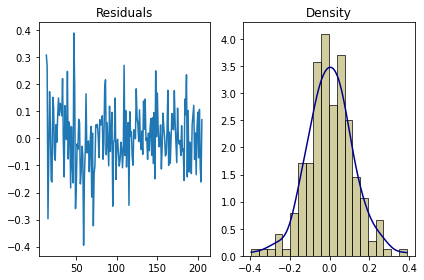

In [103]:
#czy reszty są białym szumem?
residuals = model_fit.resid[d+12:] #jeżeli sezonowy +M
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
sns.histplot(residuals, color='#A49C41', edgecolor="black", bins=20, kde=True, stat="density", ax=ax[1]).lines[0].set_color('darkblue')
plt.ylabel('')
plt.title('Density')
plt.tight_layout()

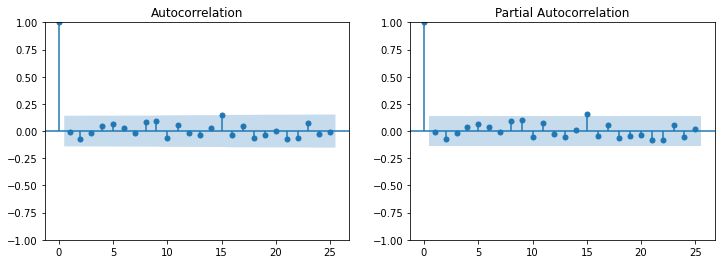

In [104]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
acf_res = plot_acf(residuals, ax=ax[0], lags=25)
pacf_res = plot_pacf(residuals, ax=ax[1], lags=25)

In [105]:
acorr_ljungbox(residuals, lags=[24], return_df=True, boxpierce=True) #test ljunga-boxa

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
24,17.54746,0.824394,16.154928,0.882403


# Make time series predictions

<AxesSubplot:xlabel='Date', ylabel='Value'>

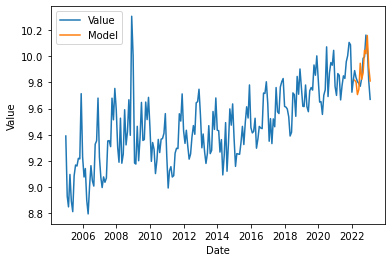

In [72]:
#dla df_test
forecast_test = model_fit.forecast(len(df_test))
df['forecast_test'] = [None]*len(df_train) + list(forecast_test)

sns.lineplot(data=df,x="Date", y="Value", label='Value')
sns.lineplot(data=df,x="Date", y="forecast_test", label='Model')

<AxesSubplot:xlabel='Date', ylabel='Value'>

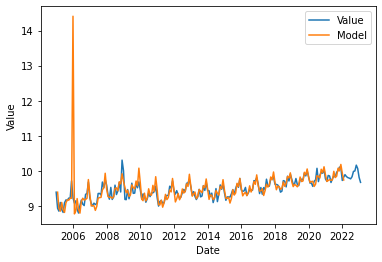

In [50]:
#dla df_train
forecast_train = model_fit.fittedvalues
df['forecast_train'] = list(forecast_train)+[None]*len(df_test)

sns.lineplot(data=df,x="Date", y="Value", label='Value')
sns.lineplot(data=df[d:],x="Date", y="forecast_train", label='Model') #jeżeli sezonowy +M

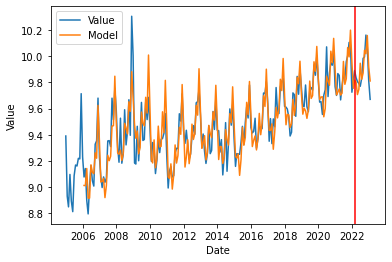

In [120]:
#dla df
forecast_train = model_fit.fittedvalues
forecast_test = model_fit.forecast(len(df_test))
df['forecast'] = list(forecast_train) + list(forecast_test)
sns.lineplot(data=df,x="Date", y="Value", label='Value')
sns.lineplot(data=df[d+12:],x="Date", y="forecast", label='Model') #jeżeli sezonowy +M
plt.legend()
plt.axvline(x=df.Date[-len(df_test):-len(df_test)+1], color='r', linestyle='-')

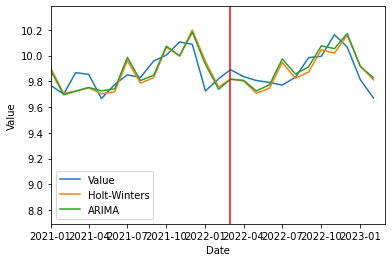

In [91]:
#dla df
forecast_train1 = model_fit1.fittedvalues
forecast_test1 = model_fit1.forecast(len(df_test))
forecast_train2 = model_fit2.fittedvalues
forecast_test2 = model_fit2.forecast(len(df_test))
df['forecast1'] = list(forecast_train1) + list(forecast_test1)
df['forecast2'] = list(forecast_train2) + list(forecast_test2)
sns.lineplot(data=df[d+12:],x="Date", y="Value", label='Value')
sns.lineplot(data=df[d+12:],x="Date", y="forecast1", label='Holt-Winters')
sns.lineplot(data=df[d+12:],x="Date", y="forecast2", label='ARIMA')
plt.xlim([pd.to_datetime('2021-01-01'), pd.to_datetime('2023-03-01')])
plt.legend()
plt.axvline(x=df.Date[-len(df_test):-len(df_test)+1], color='r', linestyle='-')

# Compare models

In [110]:
#Błąd prognozy (out-of-sample)
mae = mean_absolute_error(df_test.Value, forecast_test)
mape = mean_absolute_percentage_error(df_test.Value, forecast_test)
mse = mean_squared_error(df_test.Value, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test.Value, forecast_test))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')

mae: 0.08774269474548024
mape: 0.008887355443140583
mse: 0.010346026674532702
rmse: 0.10171542004304314


In [123]:
#Błąd dopasowania (in-sample)
mae = mean_absolute_error(df_train.Value[d:], forecast_train[d:])
mape = mean_absolute_percentage_error(df_train.Value[d:], forecast_train[d:])
mse = mean_squared_error(df_train.Value[d:], forecast_train[d:])
rmse = np.sqrt(mean_squared_error(df_train.Value[d:], forecast_train[d:]))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')

mae: 0.08715985593781363
mape: 0.009187371637943562
mse: 0.012410239319534435
rmse: 0.111401253671287


In [20]:
#Błąd całościowy
mae = mean_absolute_error(df.Value[d:], df.forecast[d:])
mape = mean_absolute_percentage_error(df.Value[d:], df.forecast[d:])
mse = mean_squared_error(df.Value[d:], df.forecast[d:])
rmse = np.sqrt(mean_squared_error(df.Value[d:], df.forecast[d:]))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')

mae: 0.08731315325694337
mape: 0.009182514819510525
mse: 0.012297004132520946
rmse: 0.11089185782788989


# Other models -> Holt's, Holt-Winters and exponential

In [118]:
#Holt-Winters (sezonowy + trend) 
model=ExponentialSmoothing(df_train.Value, trend='additive', seasonal='multiplicative', seasonal_periods=M) #additive, multiplicative, None
model_fit=model.fit() #smoothing_level=a, smoothing_trend=b, smoothing_seasonal=y
model_fit.summary()

Dep. Variable:,Value,No. Observations:,206
Model:,ExponentialSmoothing,SSE,2.558
Optimized:,True,AIC,-872.083
Trend:,Additive,BIC,-818.837
Seasonal:,Multiplicative,AICC,-868.425
Seasonal Periods:,12,Date:,"Sat, 17 Jun 2023"
Box-Cox:,False,Time:,19:48:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2287080,alpha,True
smoothing_trend,1.0463e-19,beta,True


In [117]:
#Holt (niesezonowy + trend) 
model=Holt(df_train.Value, exponential=True) #exponential=True
model_fit=model.fit() #smoothing_level=a, smoothing_trend=b
model_fit.summary()

Dep. Variable:,Value,No. Observations:,206
Model:,Holt,SSE,7.453
Optimized:,True,AIC,-675.755
Trend:,Multiplicative,BIC,-662.443
Seasonal:,None,AICC,-675.333
Seasonal Periods:,None,Date:,"Sat, 17 Jun 2023"
Box-Cox:,False,Time:,19:48:48
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5262645,alpha,True
smoothing_trend,0.000000,beta,True


In [152]:
#Wykładniczy (niesezonowy + brak trendu) 
model=SimpleExpSmoothing(df_train.Value)
model_fit=model.fit(smoothing_level=0.5) #smoothing_level=0.8
model_fit.summary()

Dep. Variable:,Value,No. Observations:,95
Model:,SimpleExpSmoothing,SSE,0.004
Optimized:,True,AIC,-958.350
Trend:,None,BIC,-953.242
Seasonal:,None,AICC,-957.905
Seasonal Periods:,None,Date:,"Sun, 11 Jun 2023"
Box-Cox:,False,Time:,21:50:14
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,4.6041697,l.0,True
